In [1]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt

In [2]:
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [3]:
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [4]:
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [5]:
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context,actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


In [6]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob


In [7]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [8]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

In [9]:
def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)
            # 7. Let VW know you're done with these objects
            vw.finish_example(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr

In [10]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

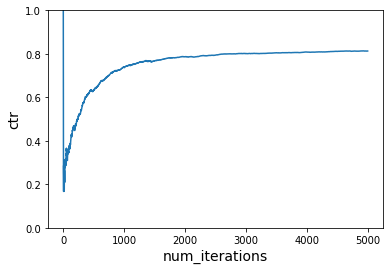

In [11]:
#FIRST SCENARIO
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

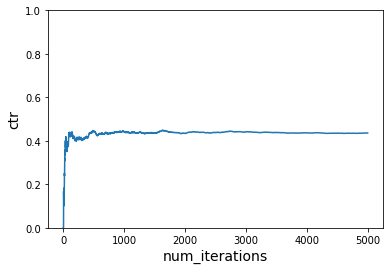

In [12]:
# Instantiate learner in VW but without -q
vw = pyvw.vw("--cb_explore_adf --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

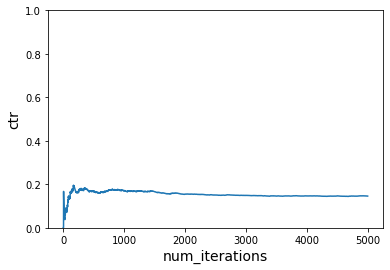

In [13]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, do_learn=False)

plot_ctr(num_iterations, ctr)

In [19]:
def get_cost_new1(context,action):
    
    ##VARYING NOISE IN REWARD DISTRIBUTION.
    
    from random import seed
    from random import random
    # seed random number generator
    seed(1)
    # generate random numbers between 0-1
    for _ in range(1):
        value = random()
        if value>0.85:
            value2 = random()
            if(value2>=0.5):
                return USER_LIKED_ARTICLE
            else:
                return USER_DISLIKED_ARTICLE
    
    ##Add multiple changes to the reward distribution over time

    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "morning" and action == 'finance':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "morning" and action == 'health':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "morning" and action == 'camping':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [20]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

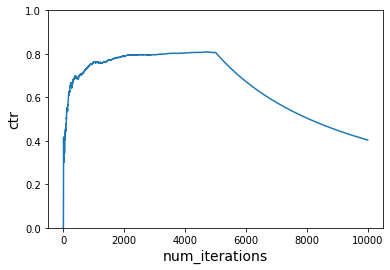

In [21]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

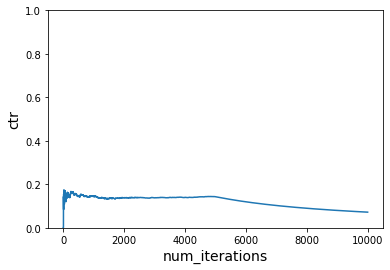

In [22]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

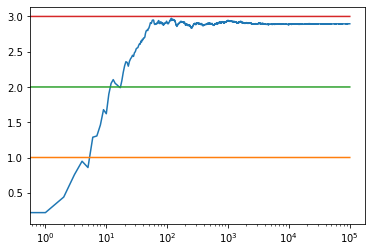

1.0079065100184048
2.012554476630258
2.996277674878436


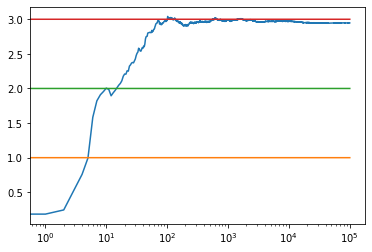

0.9949506246816915
2.0135595290513155
2.9989006017386344


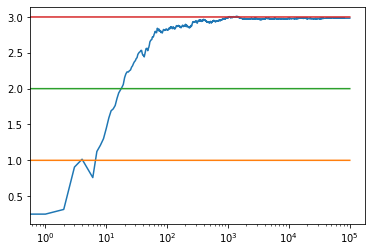

1.0037294515554376
2.02143276135794
2.9929409574044645


In [25]:
##epsilon greedy

# Import required libraries 
import numpy as np 
import matplotlib.pyplot as plt 

# Define Action class 
class Actions: 
    def __init__(self, m): 
        self.m = m 
        self.mean = 0
        self.N = 0

    # Choose a random action 
    def choose(self): 
        return np.random.randn() + self.m 

    # Update the action-value estimate 
    def update(self, x): 
        self.N += 1
        self.mean = (1 - 1.0 / self.N)*self.mean + 1.0 / self.N * x 

def run_experiment(m1, m2, m3, eps, N): 
    actions = [Actions(m1), Actions(m2), Actions(m3)] 
    data = np.empty(N) 
    
    for i in range(N): 
        p = np.random.random() 
        if p < eps: 
            j = np.random.choice(3) 
        else: 
            j = np.argmax([a.mean for a in actions]) 
        x = actions[j].choose() 
        actions[j].update(x) 

        # for the plot 
        data[i] = x 
    cumulative_average = np.cumsum(data) / (np.arange(N) + 1) 
      # plot moving average ctr 
    plt.plot(cumulative_average) 
    plt.plot(np.ones(N)*m1) 
    plt.plot(np.ones(N)*m2) 
    plt.plot(np.ones(N)*m3) 
    plt.xscale('log') 
    plt.show() 

    for a in actions: 
        print(a.mean) 
    return cumulative_average 
  
if __name__ == '__main__':       
    c_1 = run_experiment(1.0, 2.0, 3.0, 0.1, 100000) 
    c_05 = run_experiment(1.0, 2.0, 3.0, 0.05, 100000) 
    c_01 = run_experiment(1.0, 2.0, 3.0, 0.01, 100000)